# 2-Echelon Vehicle Routing Problem

* [Intro](#Intro)
* [Initial Setup](#init)
* [Parsing Google Places API](#places)
* [Clustering. Part 1](#cl1)
    * [Silhouette analysis for KMeans (Euclidean distances)](#sil_km)
    * [KMeans with 4 clusters](#km4)
    * [Plotting KMeans clustering on Google Maps](#km_gm)
* [Finding distance matrix](#dm)
    * [Parsing Google Distance Matrix API](#gdm)
* [Clustering. Part 2](#cl2)
    * [Agglomerative Clustering](#agl)
    * [Agglomerative Clustering for walking distances](#agl_w)
    * [Agglomerative Clustering for driving distances](#agl_dr)

<a name="intro"></a>
## Intro

This notebook researches the solution of the 2 echelon VRP in the city of Kyiv for delivery to the post offices of the Nova Poshta company.

All the data is initialized, computed and retrieved from scratch using Google Maps API and other open-source solutions.

At the moment, all the code is reproducible if the `data` folder is present. However, in the case of the need of any modifications, you will need to input your own API key for Google Maps API.

In [1]:
api_key = "<API_KEY>"

<a name="init"></a>
## Initial setup

Google Maps API only returns up to 60 results, so in order to obtain a minimum of 100 points, we would have to define two points within the city and input the same search query in an attempt to obtain the desired result.

Instead, let's define 4 points -- the borders of the researched rectangular area.

In [2]:
bl = (50.381347, 30.442942)
tl = (50.533611, 30.442942)
tr = (50.533611, 30.65)
br = (50.381347, 30.65)

borders = {"bl": bl,
           "tl": tl,
           "tr": tr,
           "br": br}

The distances between the two diagonals (`bl` <-> `tr` & `br` <-> `tl`) is approximately 22 km.

In order to get the most results, we need to specify circles halfway to the center with the diameter of half the diagonal. This will result in some overlapping, but the whole area will be covered.

Moreover, we will drop the results with coordinates above or below the defined rectangle to ensure we only consider customers within the rectangle.

In [3]:
import numpy as np

In [4]:
c1 = (bl[0] + (tr[0] - bl[0]) / 4, bl[1] + (tr[1] - bl[1]) / 4)
c2 = (bl[0] + (tr[0] - bl[0]) / 4 * 3, bl[1] + (tr[1] - bl[1]) / 4 * 3)
c3 = (tl[0] + (br[0] - tl[0]) / 4, br[1] + (tl[1] - br[1]) / 4 * 3)
c4 = (tl[0] + (br[0] - tl[0]) / 4 * 3, br[1] + (tl[1] - br[1]) / 4)

r1 = np.linalg.norm(np.array(bl) - np.array(tr)) / 4
r2 = np.linalg.norm(np.array(br) - np.array(tl)) / 4

centers = {"c1": c1,
           "c2": c2,
           "c3": c3,
           "c4": c4}

In [5]:
import matplotlib.pyplot as plt

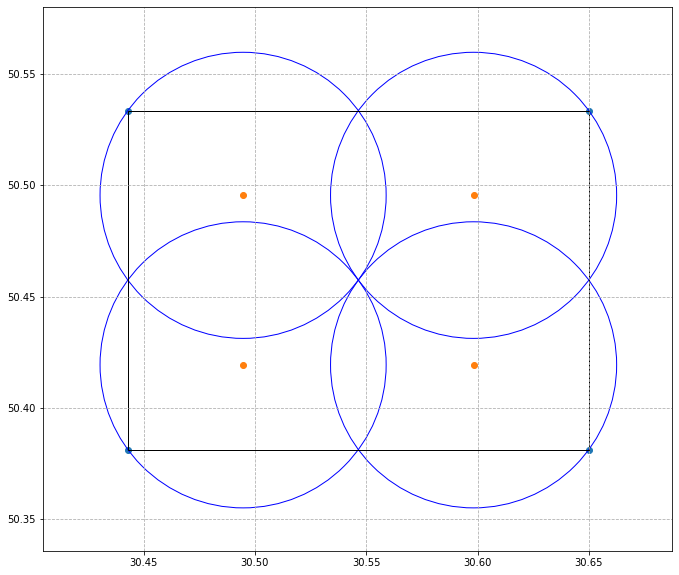

In [6]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.xlim(centers['c1'][1] - r1*1.4, centers['c1'][1] + r1*3)
plt.ylim(centers['c1'][0] - r1*1.3, centers['c1'][0] + r1*2.5)
circle1 = plt.Circle((centers['c1'][1], centers['c1'][0]), r1, color = 'blue', fill = False)
circle2 = plt.Circle((centers['c2'][1], centers['c2'][0]), r1, color = 'blue', fill = False)
circle3 = plt.Circle((centers['c3'][1], centers['c3'][0]), r2, color = 'blue', fill = False)
circle4 = plt.Circle((centers['c4'][1], centers['c4'][0]), r2, color = 'blue', fill = False)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
ax.scatter(*zip(*[(x, y) for (y, x) in borders.values()]))
ax.scatter(*zip(*[(x, y) for (y, x) in centers.values()]))

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(rectangle)
plt.show()

In [7]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(bl[0])
lon1 = radians(bl[1])
lat2 = radians(tr[0])
lon2 = radians(tr[1])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print(f"The diagonals of the rectagle are {distance:.2f} km.")

The diagonals of the rectagle are 22.40 km.


In [8]:
radius = distance / 4 * 1e3
print(f"The radius of each circle is {radius:.0f} m.")

The radius of each circle is 5600 m.


<a name="places"></a>
## Parsing Google Places API

In [9]:
from time import time, sleep
import pandas as pd
import googlemaps

In [10]:
loc_parsed_df = 'data/parsed_np.csv'

In [11]:
try:
    df = pd.read_csv(loc_parsed_df)
except:
    gmaps = googlemaps.Client(key = api_key)
    del df
    for center in centers.keys():
        print(centers[center])
        has_next_page = True
        first_page = True
        while has_next_page:
            if first_page:
                response = gmaps.places(query = "nova poshta", location = centers[center], radius = radius)
                first_page = False
            else:
                response = gmaps.places(query = "nova poshta", location = centers[center], radius = radius, page_token = next_page_token)
            try:
                next_page_token = response["next_page_token"]
                print(next_page_token)
            except:
                has_next_page = False
            try:
                df = pd.concat([df, pd.DataFrame(response['results'])])
            except:
                df = pd.DataFrame(response['results'])
            print(df.shape)
            sleep(5)
    df.drop_duplicates(subset = 'formatted_address', inplace = True)
df.head()

,formatted_address,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,reference,types,user_ratings_total
0,"Saksahanskoho St, 76, Kyiv, Ukraine, 01032","{'location': {'lat': 50.44027639999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,1d972a04859d4fab983732eccad4c6dd411a9c7d,Nova Poshta,{'open_now': True},"[{'height': 4160, 'html_attributions': ['<a hr...",ChIJHw_UA_HO1EARC2d-Q4YGvBg,"{'compound_code': 'CGR2+4G Kyiv, Kyiv city', '...",3.8,ChIJHw_UA_HO1EARC2d-Q4YGvBg,"['post_office', 'finance', 'point_of_interest'...",417
1,"Київ, Бульварно-Кудрявська, ран. Воровського, ...","{'location': {'lat': 50.450083, 'lng': 30.4962...",https://maps.gstatic.com/mapfiles/place_api/ic...,1b10a884a4808f76fd0784247e54989c458a656f,Nova Poshta,{'open_now': True},"[{'height': 3456, 'html_attributions': ['<a hr...",ChIJT1wtIGDO1EARDscyDRzUTPA,"{'compound_code': 'FF2W+2F Kyiv, Kyiv city', '...",4.3,ChIJT1wtIGDO1EARDscyDRzUTPA,"['point_of_interest', 'establishment']",192
2,"Preobrazhenska St, 8б, Kyiv, Ukraine, 03037","{'location': {'lat': 50.4242448, 'lng': 30.472...",https://maps.gstatic.com/mapfiles/place_api/ic...,e3d7c7406b127e42cec679d222035d549118d596,Nova Poshta №240,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJTw2tusfO1EARWh7P_e6if-o,"{'compound_code': 'CFFC+MX Kyiv, Kyiv city', '...",4.2,ChIJTw2tusfO1EARWh7P_e6if-o,"['point_of_interest', 'establishment']",595
3,"маг.""Фуршет, Lesi Ukrainky Blvd, 5, Kyiv, Ukra...","{'location': {'lat': 50.4352113, 'lng': 30.530...",https://maps.gstatic.com/mapfiles/place_api/ic...,c0e0477b2ad6ba0fea0f41a79352459471502f3e,Nova Poshta,{'open_now': True},"[{'height': 2448, 'html_attributions': ['<a hr...",ChIJk2oxTQHP1EARKlmkVD6n2PU,"{'compound_code': 'CGPJ+33 Kyiv, Kyiv city', '...",4.0,ChIJk2oxTQHP1EARKlmkVD6n2PU,"['point_of_interest', 'establishment']",115
4,"Київ, Шота Руставелі, 31а (м. ""Палац спорту, K...","{'location': {'lat': 50.4372615, 'lng': 30.518...",https://maps.gstatic.com/mapfiles/place_api/ic...,a28abba3956efb2bc79f6701bfaaf68776906d16,Nova Poshta,{'open_now': True},"[{'height': 3264, 'html_attributions': ['<a hr...",ChIJm9qlhf7O1EARZQ5CXQ2Cgy0,"{'compound_code': 'CGP9+WG Kyiv, Kyiv city', '...",4.2,ChIJm9qlhf7O1EARZQ5CXQ2Cgy0,"['point_of_interest', 'establishment']",146


In [12]:
print(f"A total of {len(df['formatted_address'].unique())} post offices were found within the 4 circles.")

A total of 135 post offices were found within the 4 circles.


In [13]:
df.reset_index(drop = True, inplace = True)
df.to_csv(loc_parsed_df, header = True, index = False)

In [14]:
import ast

df['lat'] = df['geometry'].apply(lambda x: ast.literal_eval(x)['location']['lat'])
df['lon'] = df['geometry'].apply(lambda x: ast.literal_eval(x)['location']['lng'])

In [15]:
df['in_square'] = ((df['lat'] > bl[0]) & (df['lat'] < tr[0]) & (df['lon'] > bl[1]) & (df['lon'] < tr[1]))

In [16]:
print(f"A total of {len(df['formatted_address'][df['in_square']].unique())} post offices found are within the considered rectangle.")

A total of 118 post offices found are within the considered rectangle.


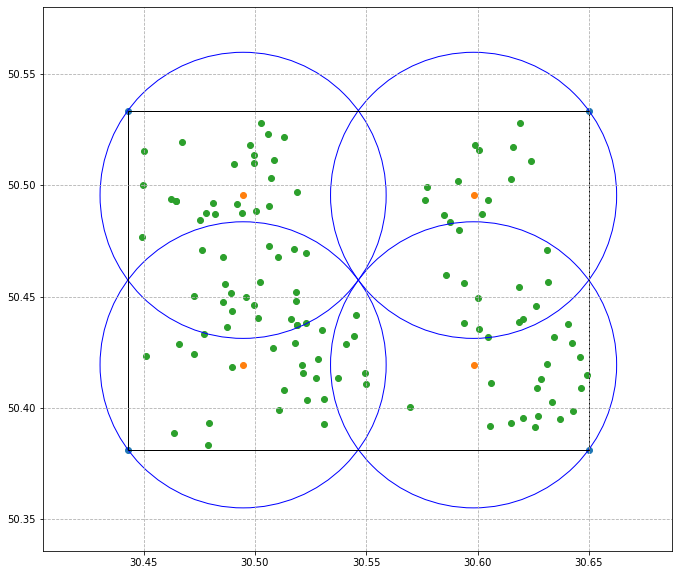

In [17]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.xlim(centers['c1'][1] - r1*1.4, centers['c1'][1] + r1*3)
plt.ylim(centers['c1'][0] - r1*1.3, centers['c1'][0] + r1*2.5)
circle1 = plt.Circle((centers['c1'][1], centers['c1'][0]), r1, color = 'blue', fill = False)
circle2 = plt.Circle((centers['c2'][1], centers['c2'][0]), r1, color = 'blue', fill = False)
circle3 = plt.Circle((centers['c3'][1], centers['c3'][0]), r2, color = 'blue', fill = False)
circle4 = plt.Circle((centers['c4'][1], centers['c4'][0]), r2, color = 'blue', fill = False)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
ax.scatter(*zip(*[(x, y) for (y, x) in borders.values()]))
ax.scatter(*zip(*[(x, y) for (y, x) in centers.values()]))

ax.scatter(df['lon'][df['in_square']], df['lat'][df['in_square']])

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(rectangle)
plt.show()

<a name="cl1"></a>
## Clustering

Let's analyze what amount of clusters is best fit for the given data points.

We will use K-means algorithm, which uses the Euclidean metric for the pairwise distance, thus there will most likely be non-optimal cluster assignments.

Let's perform the Silhouette analysis for cluster numbers from 2 to 6. 1 is redundant and everything above 6 is not viable for our considered task.

In [18]:
clusters_df = df[['lat', 'lon', 'user_ratings_total', 'rating']][df['in_square']]
clusters_df['user_ratings_total_scaled'] = clusters_df['user_ratings_total'] / clusters_df['user_ratings_total'].max()
clusters_df['weighted_ratings'] = clusters_df['rating'] * clusters_df['user_ratings_total'] / (clusters_df['rating'] * clusters_df['user_ratings_total']).max()
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings
0,50.440276,30.501372,417,3.8,0.319540,0.296159
1,50.450083,30.496220,192,4.3,0.147126,0.154303
2,50.424245,30.472491,595,4.2,0.455939,0.467059
3,50.435211,30.530175,115,4.0,0.088123,0.085973
4,50.437261,30.518789,146,4.2,0.111877,0.114606


<a name="sil_km"></a>
### Silhouette analysis for KMeans (Euclidean distances)

In [19]:
X = clusters_df[['lat', 'lon']]

For n_clusters = 2 The average silhouette_score is : 0.5313525718118249
For n_clusters = 3 The average silhouette_score is : 0.47991360883988454
For n_clusters = 4 The average silhouette_score is : 0.4984763926878794
For n_clusters = 5 The average silhouette_score is : 0.47953602643476456
For n_clusters = 6 The average silhouette_score is : 0.45717502982804253


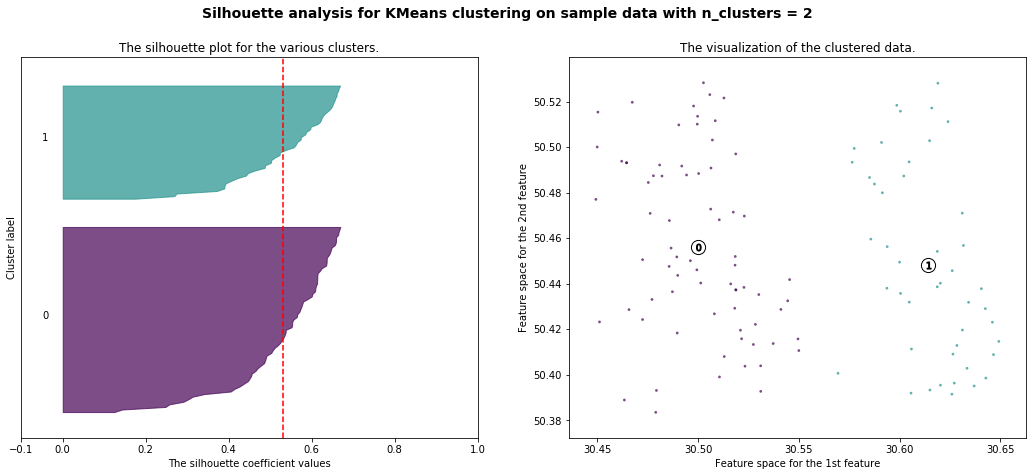

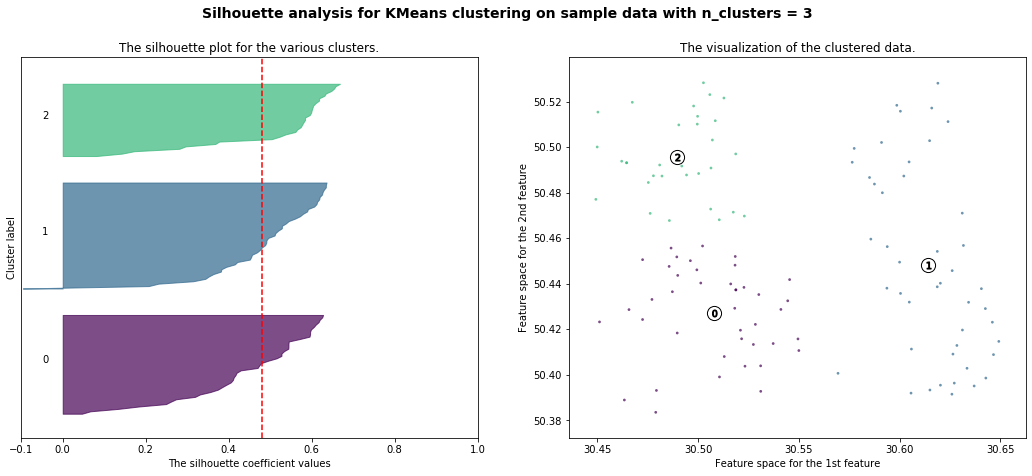

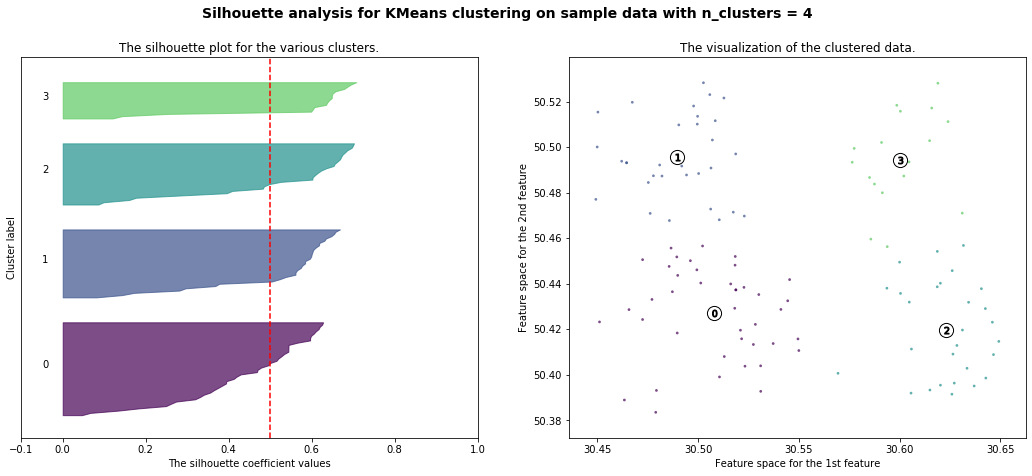

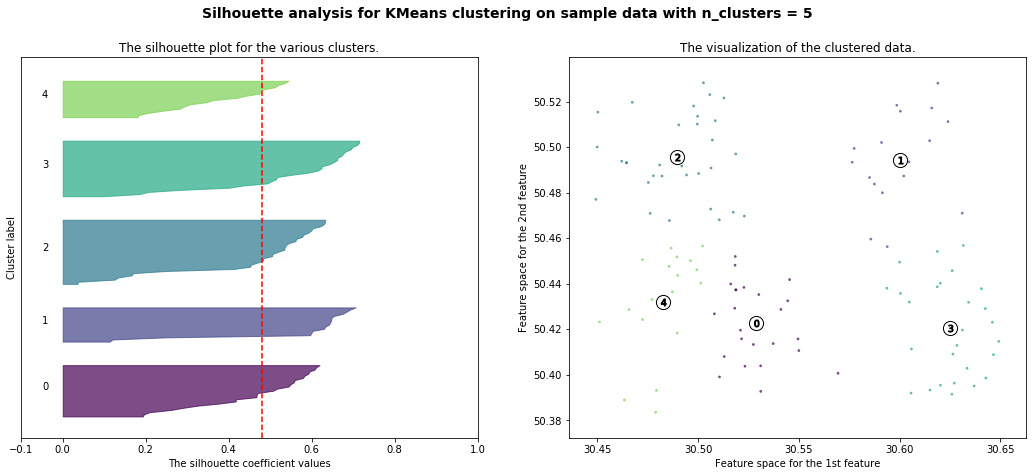

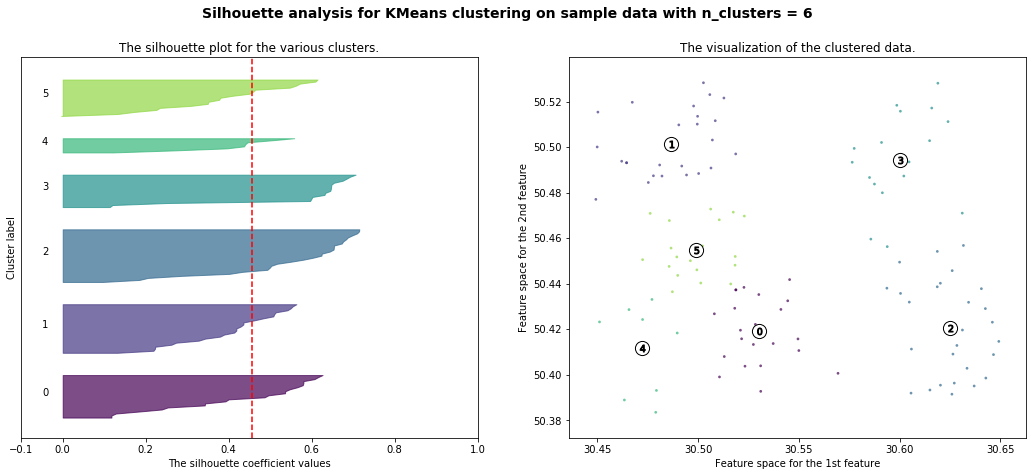

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Defining a range of clusters to search in
range_n_clusters = range(2, 7, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusters_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 1], X.iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    center_points = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(center_points[:, 1], center_points[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(center_points):
        ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As Silhouette analysis demonstrates, 4 is the optimal number of clusters to break down the data points. We will not be using 2 as another oversimplistic version.

<a name="km4"></a>
### KMeans with 4 clusters

In [21]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

In [22]:
def calculate_color(clust):
    """
    Convert cluster number to a color
    """
    # transform the gini coefficient to a matplotlib color
    mpl_color = viridis(clust / num_clusters)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha = False)

    return gmaps_color

In [23]:
num_clusters = 4
kmeans = KMeans(n_clusters = num_clusters).fit(clusters_df[['lat', 'lon']])
centroids = kmeans.cluster_centers_
print(centroids)

[[50.49543372 30.48969494]
 [50.41978153 30.62298615]
 [50.42705734 30.50797268]
 [50.4944713  30.60000928]]


In [24]:
clusters_df['cluster'] = kmeans.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,2,#21918c
1,50.450083,30.496220,192,4.3,0.147126,0.154303,2,#21918c
2,50.424245,30.472491,595,4.2,0.455939,0.467059,2,#21918c
3,50.435211,30.530175,115,4.0,0.088123,0.085973,2,#21918c
4,50.437261,30.518789,146,4.2,0.111877,0.114606,2,#21918c


<a name="km_gm"></a>
### Plot of KMeans clustering on Google Maps

In [25]:
import gmaps

In [26]:
gmaps.configure(api_key = api_key)

In [29]:
lat = bl[0] + (tr[0] - bl[0]) / 2
lon = bl[1] + (tr[1] - bl[1]) / 2
print(f"Plotting the map centered at ({lat:.4f}, {lon:.4f}).")

Plotting the map centered at (50.4575, 30.5465).


In [28]:
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
fig = gmaps.figure(center = (lat, lon), zoom_level = 12, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

centers_layer = gmaps.symbol_layer(
        kmeans.cluster_centers_,
        fill_color = "#ff007f",
        stroke_color = "#ff007f",
        scale = 5)
fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

Plotting weighted ratings of the post offices colored in the colors of one of the 6 assigned.


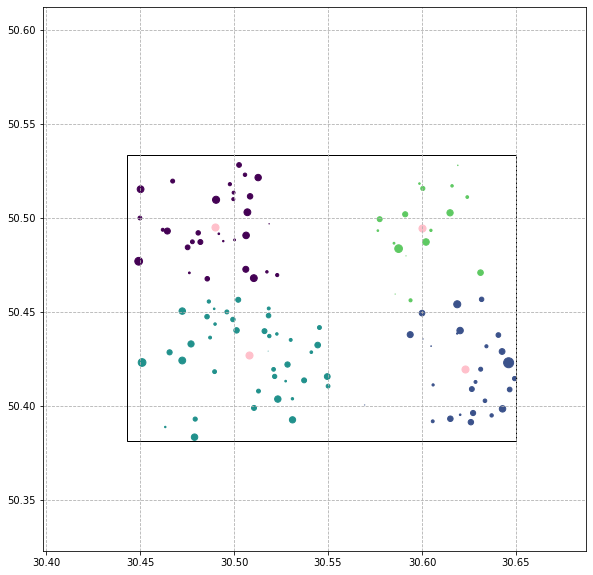

In [30]:
print(f"Plotting weighted ratings of the post offices colored in the colors of one of the {n_clusters} assigned.")
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.ylim(centers['c1'][0] - r1*1.5, centers['c1'][0] + r1*3)
plt.xlim(centers['c1'][1] - r1*1.5, centers['c1'][1] + r1*3)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
size_series = clusters_df['weighted_ratings'] * 100
ax.scatter(clusters_df['lon'], clusters_df['lat'], s = size_series, c = clusters_df['color'])
ax.scatter(centroids[:, 1], centroids[:, 0], c='pink', s=50)
ax.add_artist(rectangle)
plt.show()

<a name="dm"></a>
## Finding distance matrix

In [31]:
from tqdm import tqdm_notebook as tqdm

<a name="gdm"></a>
### Parsing Google Distance Matrix API

#### Parsing GDM to obtain driving distances

In [32]:
loc_dist_matrix = "data/distances_driving.npy"

In [33]:
try:
    matrix_driving = np.load(loc_dist_matrix)
except:
    matrix_driving = np.empty((len(clusters_df), len(clusters_df)))
    columns = len(clusters_df)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(clusters_df))):
        for column in tqdm(range(columns)):
            origins = (clusters_df['lat'].iloc[row], clusters_df['lon'].iloc[row])
            destination = (clusters_df['lat'].iloc[column], clusters_df['lon'].iloc[column])
            distance = gmaps_api.distance_matrix(origins, destination, mode='driving')["rows"][0]["elements"][0]["distance"]["value"]
            matrix_driving[row, column] = distance
        sleep(5)
    np.save(loc_dist_matrix, matrix_driving)

In [34]:
matrix_driving

array([[    0.,  1418.,  3594., ..., 12426.,  5902., 13264.],
       [ 2089.,     0.,  4617., ..., 13224.,  6975., 14506.],
       [ 4017.,  4679.,     0., ..., 13393.,  6868., 14231.],
       ...,
       [12197., 11940., 13259., ...,     0.,  9991.,  7167.],
       [ 6578.,  7397.,  9117., ...,  6652.,     0.,  7491.],
       [13976., 12427., 14584., ...,  8400., 11491.,     0.]])

#### Parsing GDM to obtain walking distances

In [35]:
loc_dist_matrix_walking = "data/distances_walking.npy"

In [36]:
try:
    matrix_walking = np.load(loc_dist_matrix_walking)
except:
    matrix_walking = np.empty((len(clusters_df), len(clusters_df)))
    columns = len(clusters_df)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(clusters_df))):
        for column in tqdm(range(columns)):
            origins = (clusters_df['lat'].iloc[row], clusters_df['lon'].iloc[row])
            destination = (clusters_df['lat'].iloc[column], clusters_df['lon'].iloc[column])
            distance = gmaps_api.distance_matrix(origins, destination, mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
            matrix_walking[row, column] = distance
        sleep(5)
    np.save(loc_dist_matrix_walking, matrix_walking)

In [37]:
matrix_walking

array([[    0.,  1418.,  3245., ...,  9535.,  4962., 10791.],
       [ 1418.,     0.,  4228., ..., 10231.,  6380., 11488.],
       [ 3245.,  4256.,     0., ..., 10958.,  6634., 13177.],
       ...,
       [ 9699., 10262., 10780., ...,     0.,  5343.,  9507.],
       [ 4934.,  6352.,  6607., ...,  5343.,     0.,  7467.],
       [10973., 11536., 13195., ...,  9507.,  7467.,     0.]])

<a name="cl2"></a>
## Clustering. Part 2

Now that we have obtained the true distance matrices for driving and walking instead of Euclidean distance metric, we can now compute a more accurate clustering distribution.

However, `sklearn` does not have KMeans clustering for custom distribution matrices, and thus we ought to seek some other clustering technique.

Let's first take a look at a fairly popular clustering algorithm, OPTICS:

### OPTICS

In [38]:
from sklearn.cluster import OPTICS

In [39]:
X = matrix_walking

In [40]:
clust = OPTICS(min_samples = 10, xi=.05, min_cluster_size=.05)
clust.fit(X)

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=10, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [41]:
set(clust.labels_)

{-1, 0, 1, 2, 3, 4}

In [42]:
clusters_df['cluster'] = clust.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,-1,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,-1,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,-1,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,-1,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,-1,#440154


In [43]:
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
fig = gmaps.figure(center = (lat, lon), zoom_level = 12, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

# centers_layer = gmaps.symbol_layer(
#         kmeans.cluster_centers_,
#         fill_color = "#ff007f",
#         stroke_color = "#ff007f",
#         scale = 5)
# fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

As observed in the plotted image, the algorithm performs rather poorly on the data points provided. Thus, we continue our quest for a better clustering instrument to obtain clusters. Our next candidate is Agglomerative Clustering.

<a name="agl"></a>
### Agglomerative Clustering

Unlike OPTICS, Agglomerative Clustering algorithm requires the number of clusters to be provided explicitly. Thus, we resort to Silhouette analysis once again to determine the optimal number of clusters.

#### Silhouette analysis for walking distances

In [44]:
X = matrix_walking

For n_clusters = 2 The average silhouette_score is : 0.47464123112016526
For n_clusters = 3 The average silhouette_score is : 0.4905534458244634
For n_clusters = 4 The average silhouette_score is : 0.5387711559407464
For n_clusters = 5 The average silhouette_score is : 0.47346922377244854
For n_clusters = 6 The average silhouette_score is : 0.4677147946916763
For n_clusters = 7 The average silhouette_score is : 0.4864971895572976
For n_clusters = 8 The average silhouette_score is : 0.45163784828291303
For n_clusters = 9 The average silhouette_score is : 0.4597822151527626
For n_clusters = 10 The average silhouette_score is : 0.44798708064541476


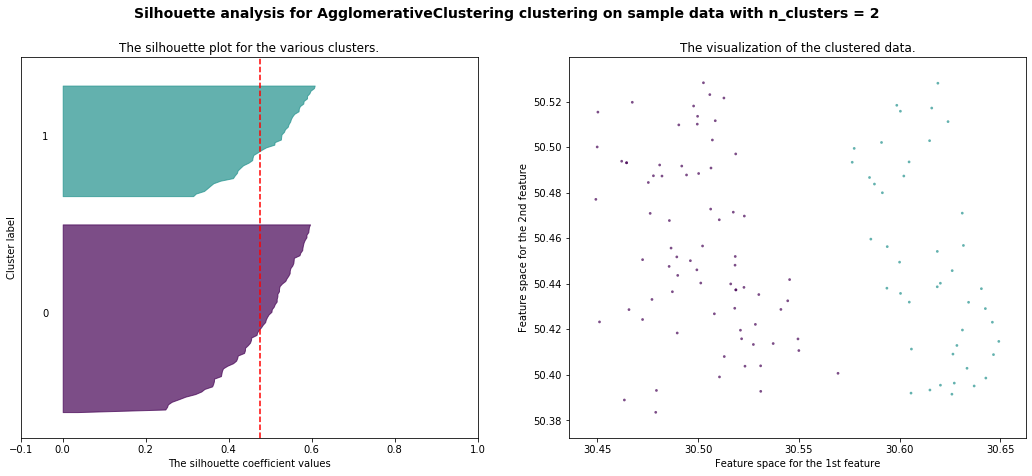

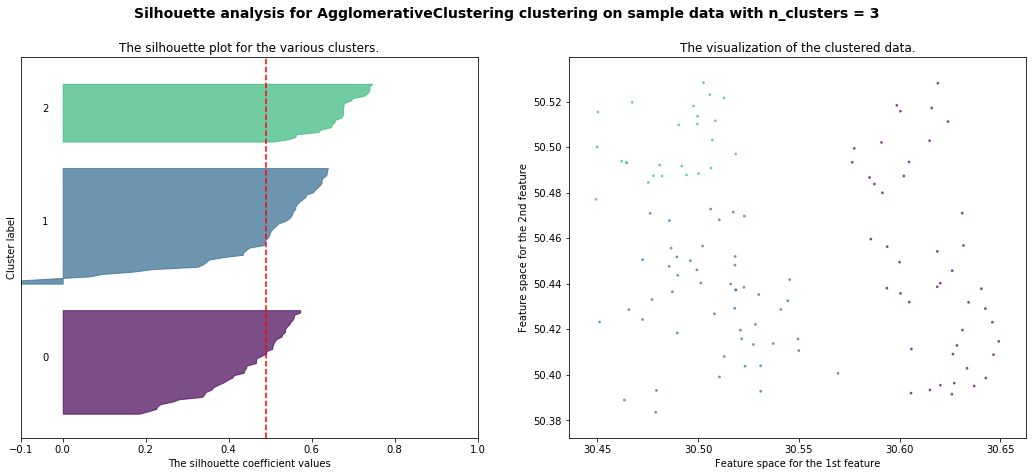

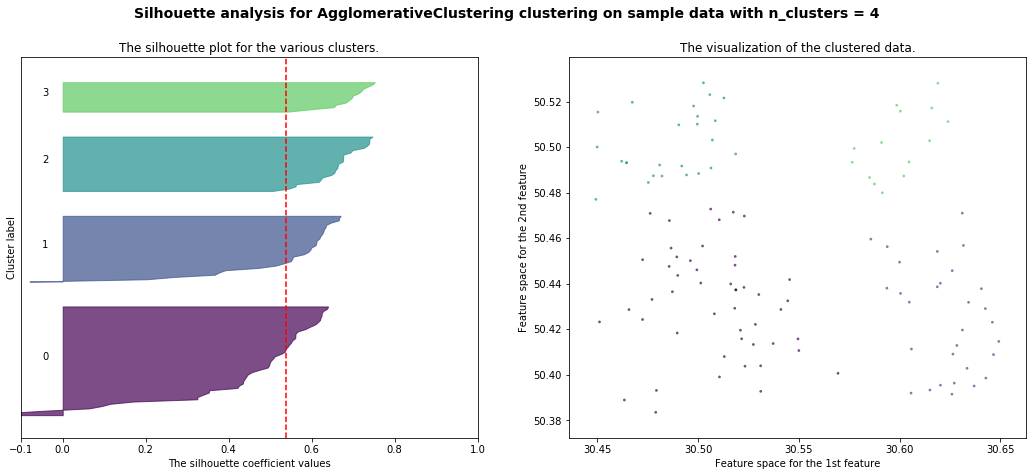

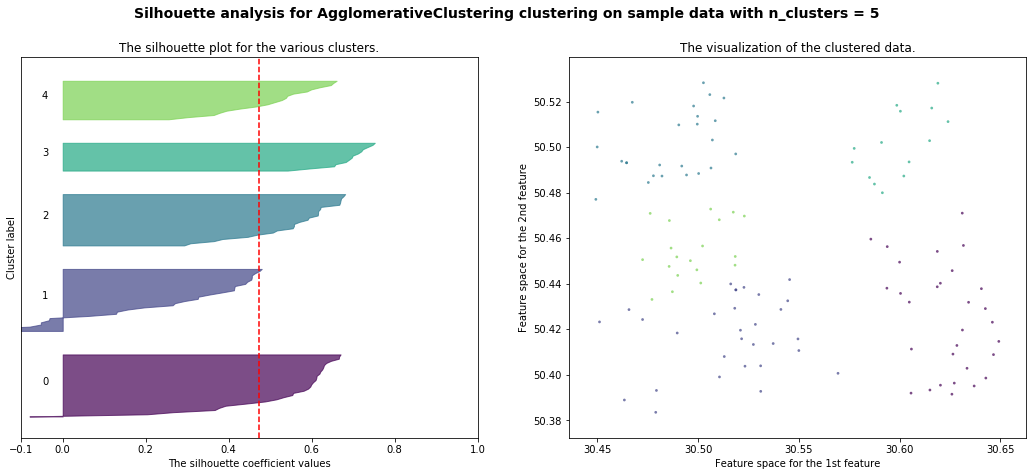

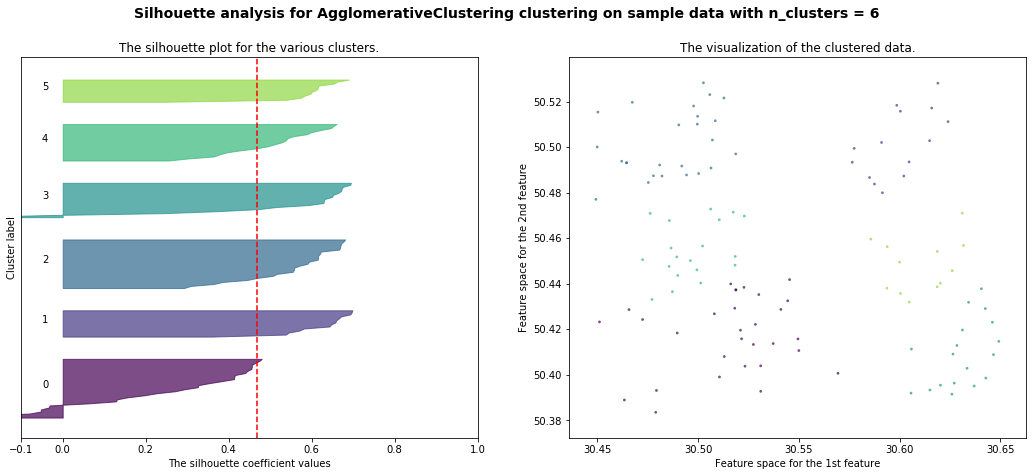

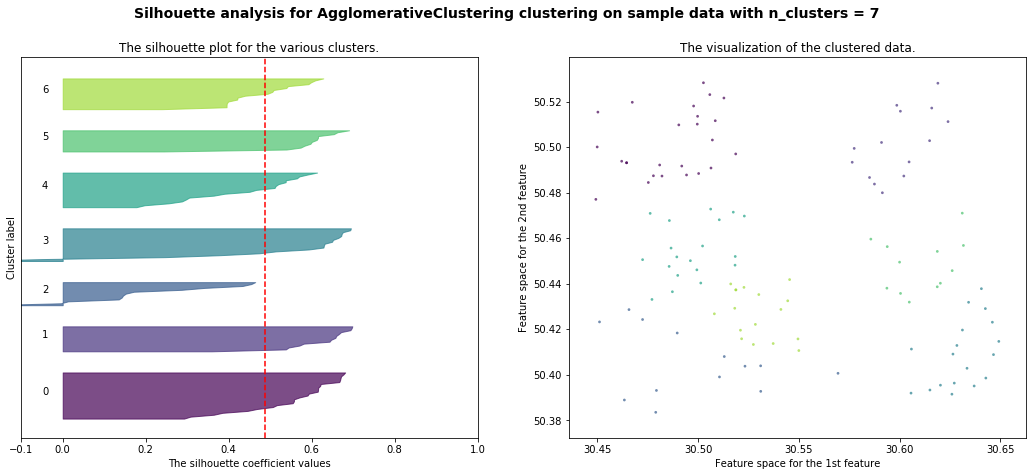

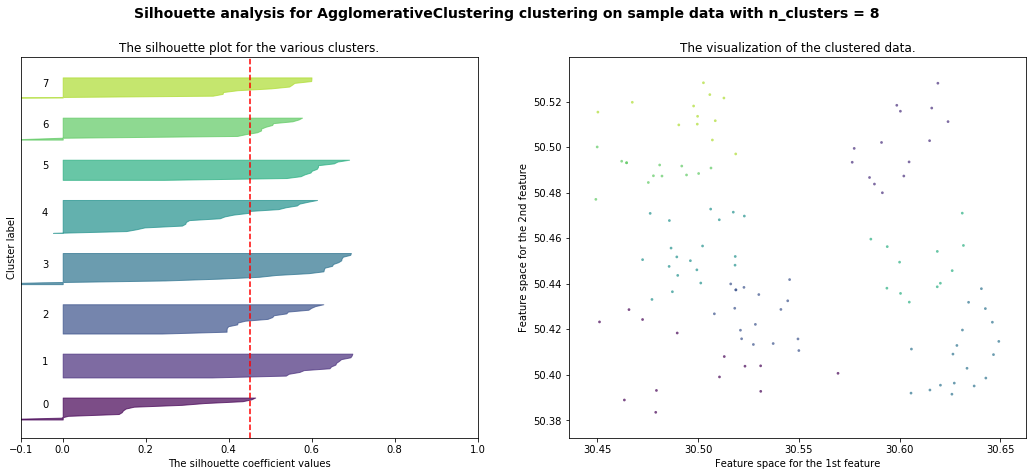

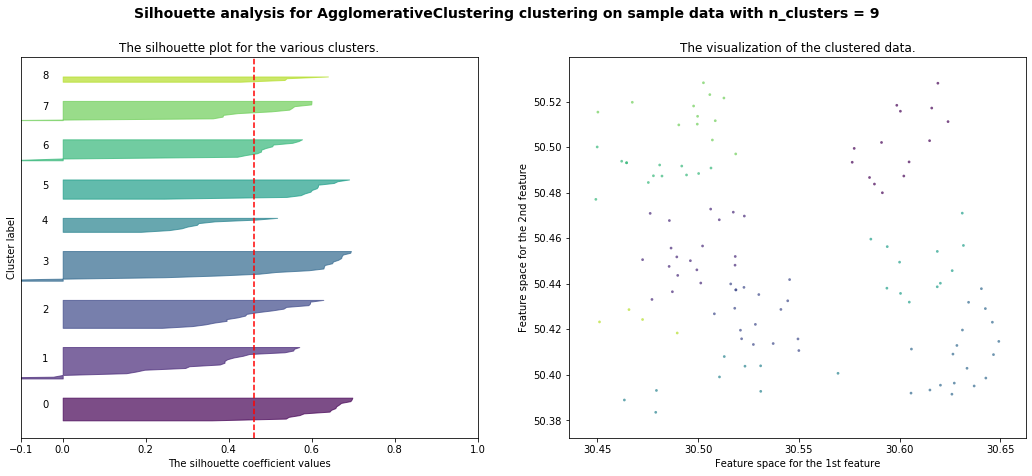

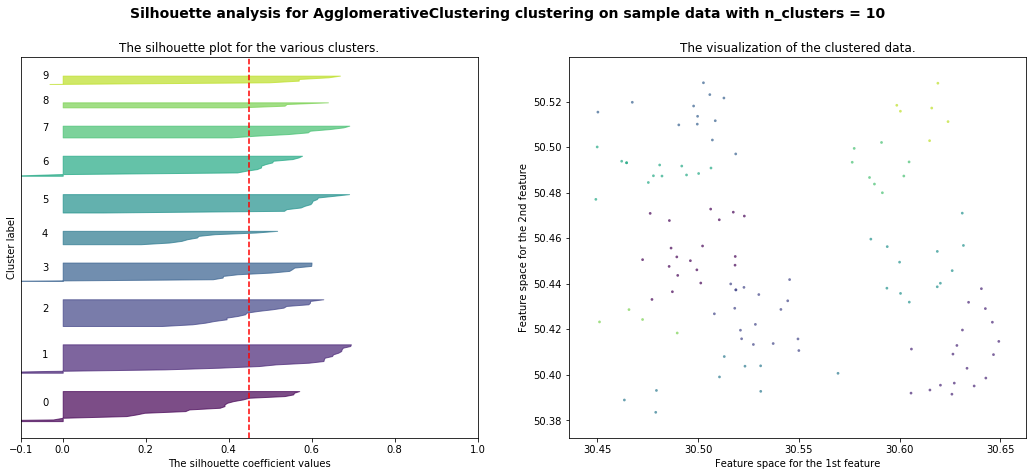

In [45]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2, 11, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(clusters_df[['lat', 'lon']].iloc[:, 1], clusters_df[['lat', 'lon']].iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for AgglomerativeClustering clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Silhouette analysis for driving distances

In [46]:
X = matrix_driving

For n_clusters = 2 The average silhouette_score is : 0.3821315755233003
For n_clusters = 3 The average silhouette_score is : 0.4294077237548883
For n_clusters = 4 The average silhouette_score is : 0.4646955777488318
For n_clusters = 5 The average silhouette_score is : 0.4316577616249155
For n_clusters = 6 The average silhouette_score is : 0.4511081139176247
For n_clusters = 7 The average silhouette_score is : 0.4239611414912252
For n_clusters = 8 The average silhouette_score is : 0.41383346250153585
For n_clusters = 9 The average silhouette_score is : 0.4091470620804474
For n_clusters = 10 The average silhouette_score is : 0.38438344857638174


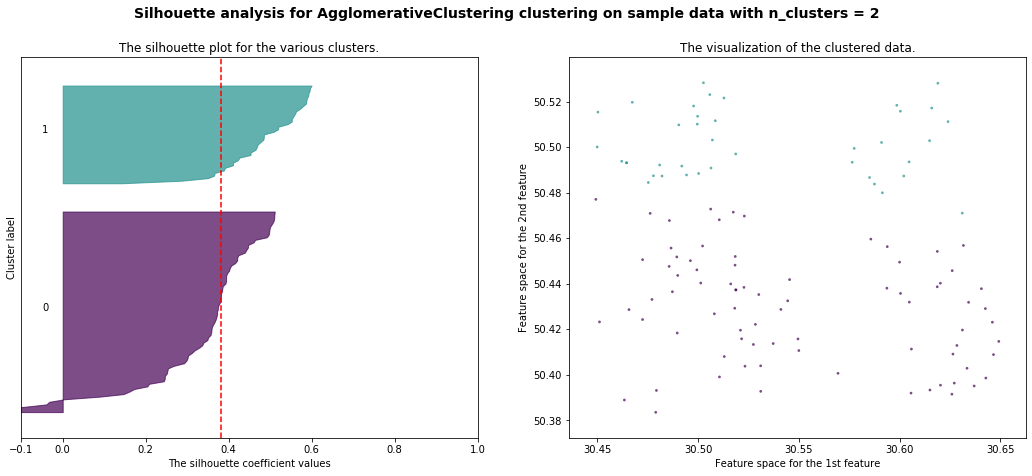

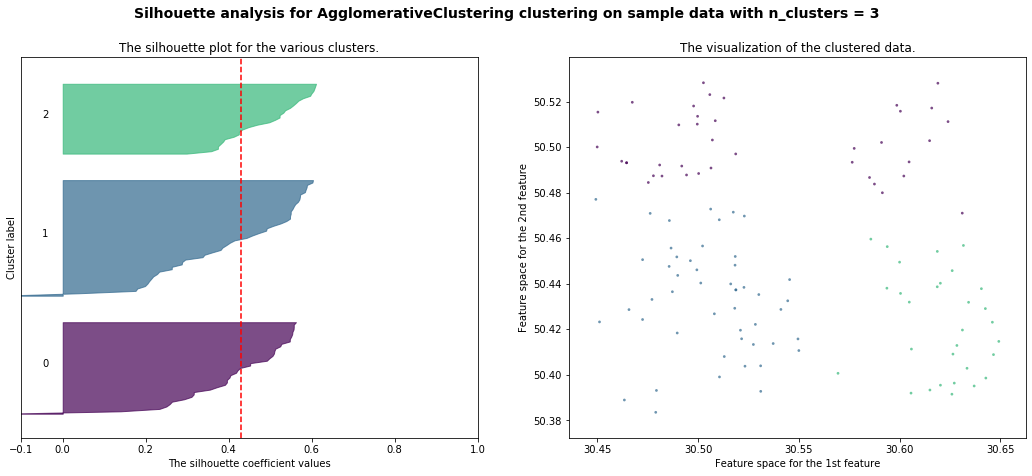

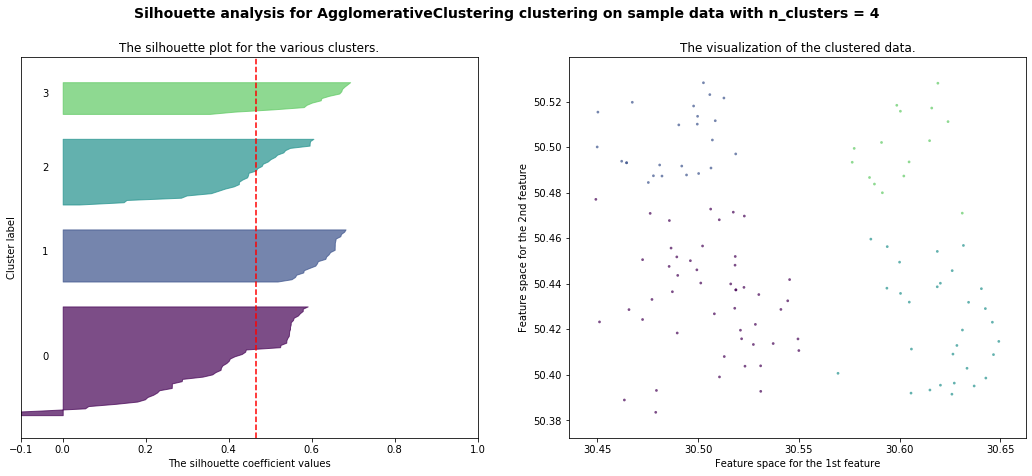

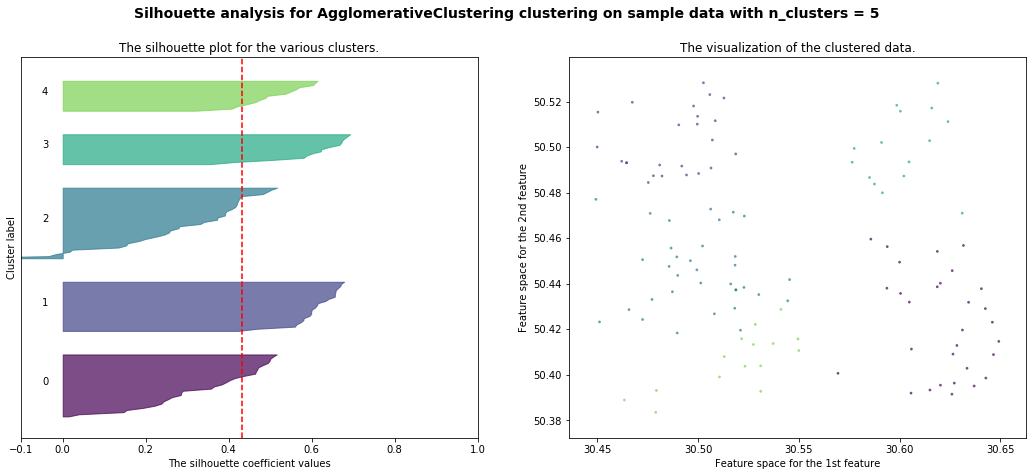

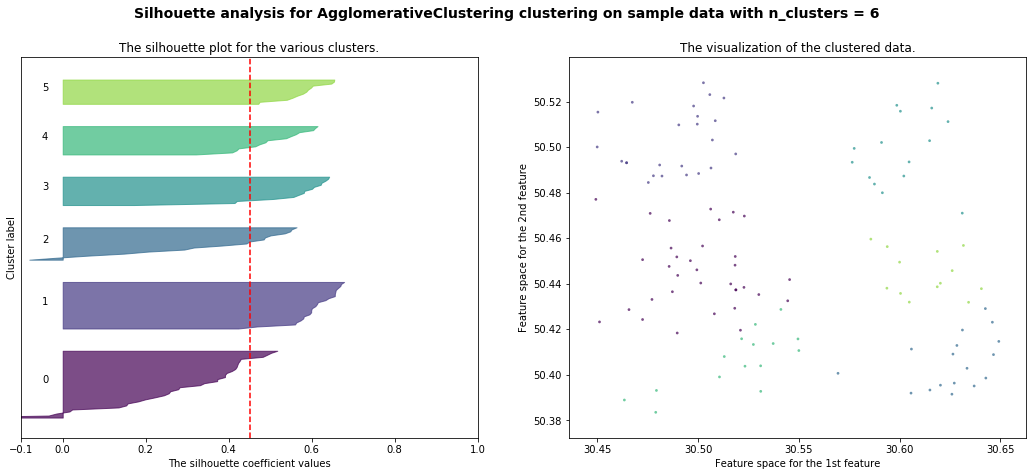

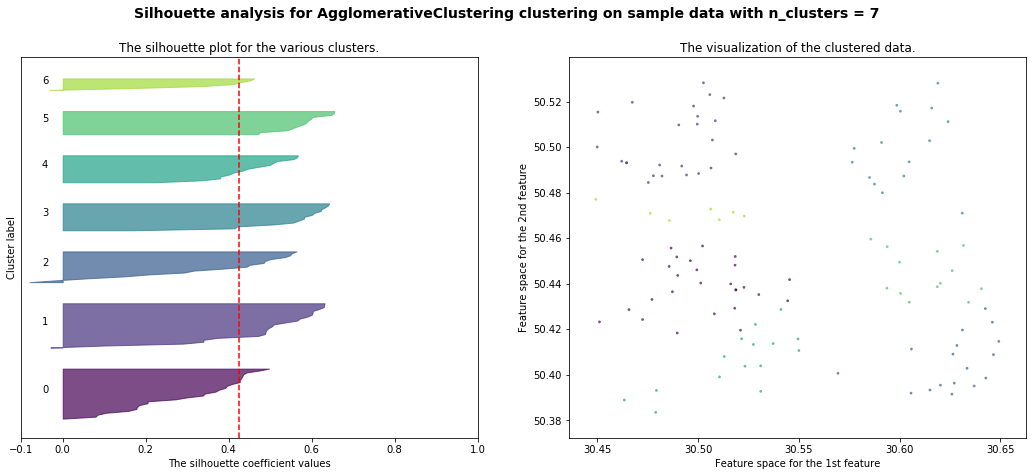

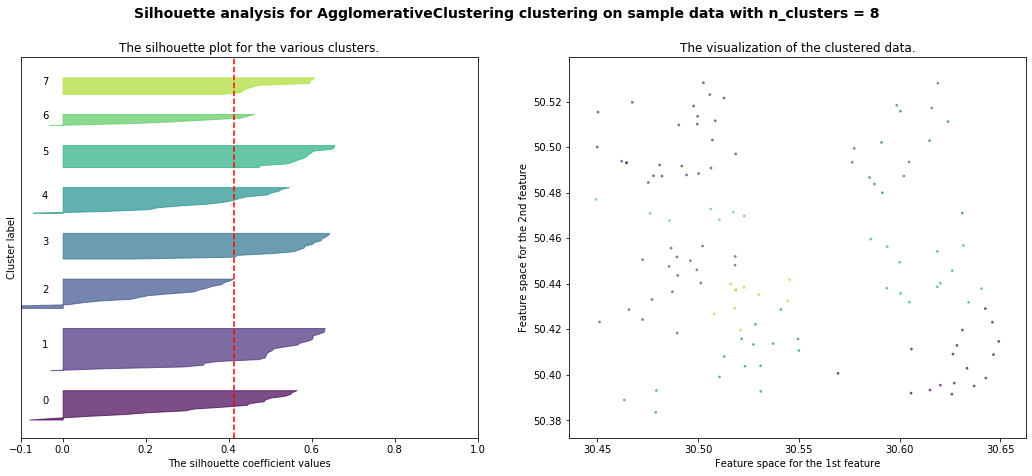

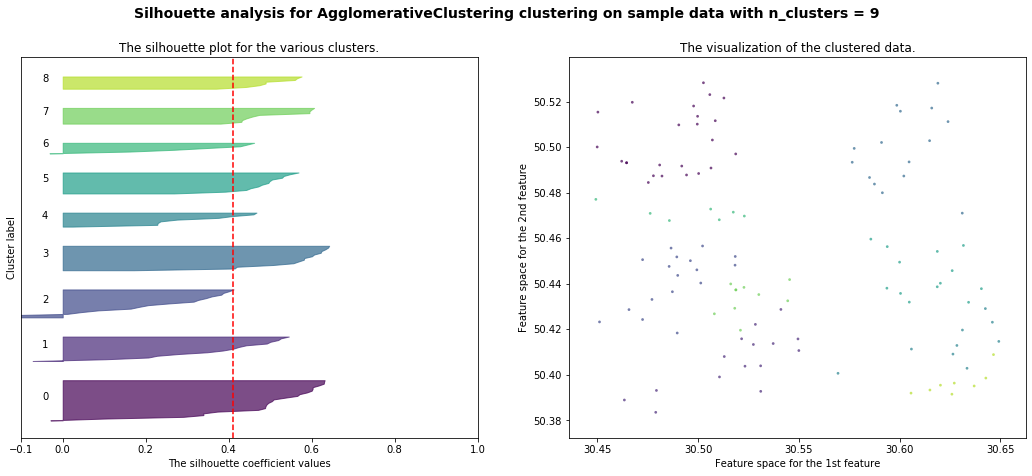

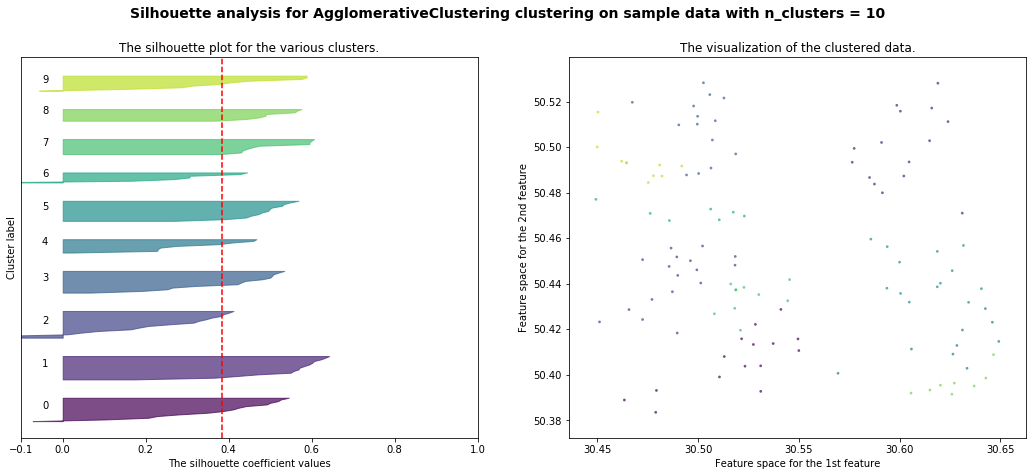

In [47]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2, 11, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(clusters_df[['lat', 'lon']].iloc[:, 1], clusters_df[['lat', 'lon']].iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for AgglomerativeClustering clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The Silhouette analysis of Agglomerative Clustering for both driving and walking distances hints us that the optimal number of clusters is 4.

In [48]:
n_clusters = 4

<a name="agl_w"></a>
### Agglomerative Clustering for walking distances

In [49]:
X = matrix_walking

In [50]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [51]:
clusters_df['cluster'] = clustering.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154


In [52]:
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
fig = gmaps.figure(center = (lat, lon), zoom_level = 12, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

# centers_layer = gmaps.symbol_layer(
#         kmeans.cluster_centers_,
#         fill_color = "#ff007f",
#         stroke_color = "#ff007f",
#         scale = 5)
# fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

<a name="agl_dr"></a>
### Agglomerative Clustering for driving distances

In [53]:
X = matrix_driving

In [54]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [55]:
clusters_df['cluster'] = clustering.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154


In [56]:
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
fig = gmaps.figure(center = (lat, lon), zoom_level = 12, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

# centers_layer = gmaps.symbol_layer(
#         kmeans.cluster_centers_,
#         fill_color = "#ff007f",
#         stroke_color = "#ff007f",
#         scale = 5)
# fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

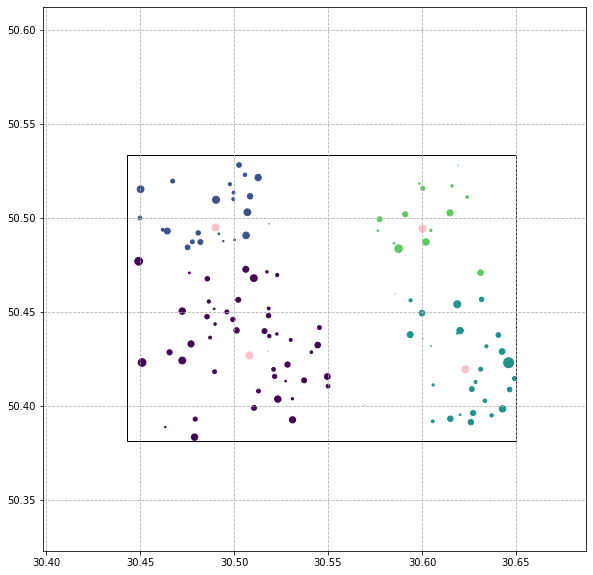

In [57]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.ylim(centers['c1'][0] - r1*1.5, centers['c1'][0] + r1*3)
plt.xlim(centers['c1'][1] - r1*1.5, centers['c1'][1] + r1*3)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
size_series = clusters_df['weighted_ratings'] * 100
ax.scatter(clusters_df['lon'], clusters_df['lat'], s = size_series, c = clusters_df['color'])
ax.scatter(centroids[:, 1], centroids[:, 0], c='pink', s=50)
ax.add_artist(rectangle)
plt.show()